In [ ]:
# Make a copy and rename this notebook when working on your branch. i.e. predictive_biomarkers_RH.ipynb

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("/Users/harunr/proj/shapml/")
from shapml import binary_classification as BC
from shapml import utils

%config Completer.use_jedi = False

# Run analysis

In [7]:
csv_path = 'data/dataset_clean.csv' # T: find out out to extract from "file=st.file_uploader('load file')"
drop_cols = ['synthetic_probability', 'asdfs'] # *T: create way to exclude model features (hint: st.multi_select), by
exposure_var = 'CTR1' #T: create UI to select exposure_var
target = 'synthetic_target'#T: select way create UI to select binary target variable

In [8]:
df_orig = pd.read_csv(csv_path)

In [9]:
final_cols2drop = [col for col in drop_cols if col in df_orig.columns]
final_cols2drop

['synthetic_probability']

In [11]:
analysis=BC.xgb_shap(df=df_orig.drop(columns=final_cols2drop),
                     target=target, exposure_var=exposure_var,
                    max_evals=5, bootstrap_iterations=100, n_folds_SHAP=5)# optional parameters set for the sake of computations efficiency
analysis.tune_model()

100%|██████████| 5/5 [00:05<00:00,  1.13s/trial, best loss: 0.20009880521725143]
Done: took 5.6553778648376465 seconds
The best hyperparameters are:  

{'eta': 0.12190960760867987, 'max_depth': 3, 'min_child_weight': 0.10704698010661089, 'reg_alpha': 8.149043639957283, 'reg_lambda': 16.193315456719624, 'subsample': 0.8977155615500958, 'objective': 'binary:logistic', 'tree_method': 'exact', 'eval_metric': 'error'}


In [12]:
fig = analysis.shap_summary_plots(show=False) # Running this performs necessary analyses
# fig # This can be optionally showed for showing feature impacts on response probability

Extracting SHAP values using 5-fold CV ...



  CV score: 0.876
  CV score (train): 0.919±0.004
   Execution time: 4.28s


# Factors that interact with exposure

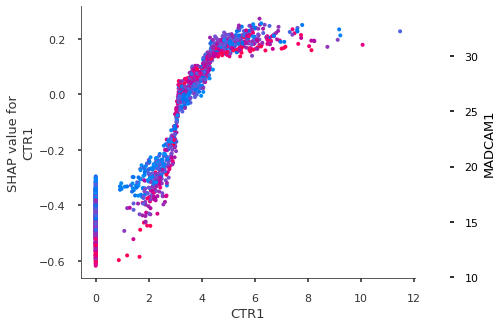

In [13]:
analysis.dependence_plot('CTR1')

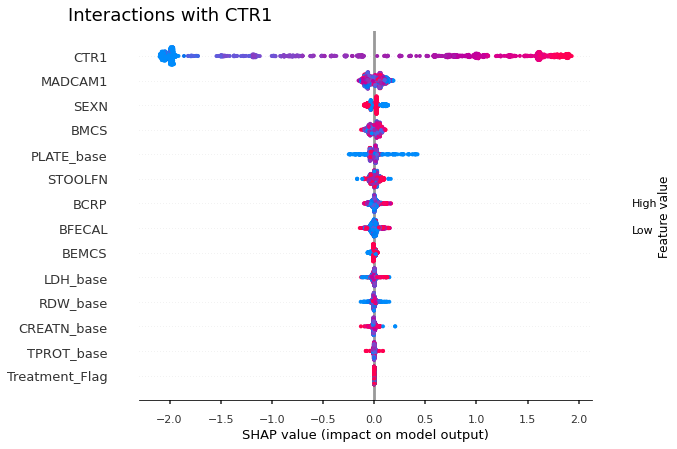

In [14]:
analysis.shap_interaction_summary(feature='CTR1')

Interaction values in probability scale were not found; using log-odds scale
Hint: self.generate_shap_exposure_interaction_prob_df(exposure_var)


,covariate,mean impact,std,covariate impact on ER
0,MADCAM1,0.064155,0.036374,0.0642±0.0364
1,SEXN,0.043316,0.031311,0.0433±0.0313
2,BMCS,0.040415,0.022021,0.0404±0.0220
3,PLATE_base,0.032275,0.048837,0.0323±0.0488
4,STOOLFN,0.026874,0.022533,0.0269±0.0225
5,BCRP,0.024945,0.024672,0.0249±0.0247
6,BFECAL,0.024626,0.026706,0.0246±0.0267
7,BEMCS,0.013299,0.011066,0.0133±0.0111
8,LDH_base,0.012279,0.017823,0.0123±0.0178
9,RDW_base,0.011826,0.015726,0.0118±0.0157


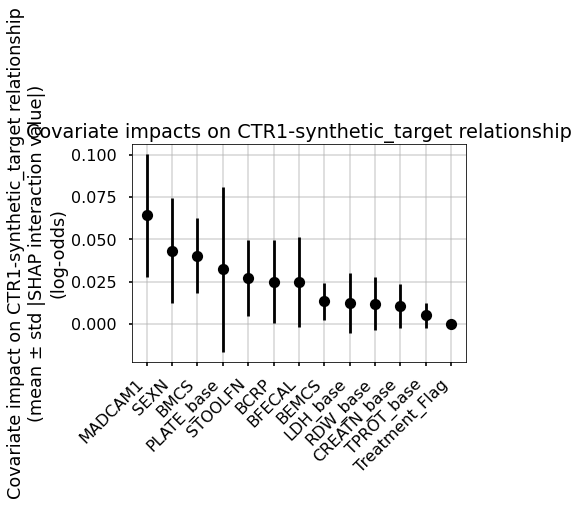

In [15]:
out = analysis.shap_exposure_impacts(exposure_var='CTR1');
out # The magniture of the impact on the exposure is of key importance (not the variance, because we expect an influential factor to have high variance)

Interaction values in probability scale were not found; using log-odds scale
Hint: self.generate_shap_exposure_interaction_prob_df(exposure_var)
Interaction values in probability scale were not found; using log-odds scale
Hint: self.generate_shap_exposure_interaction_prob_df(exposure_var)
Interaction values in probability scale were not found; using log-odds scale
Hint: self.generate_shap_exposure_interaction_prob_df(exposure_var)
No dose_var was supplied assumming placebo pts using: ((df[exposure_var]==0)
No dose_var was supplied assumming Tx pts using: (df[exposure_var].isna()) | (df[exposure_var]>0)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


Tx-related risk difference for MADCAM1≤18 : 0.333
Tx-related risk difference for MADCAM1>18 : 0.582
Group with greater risk difference:  MADCAM1>18
synthetic_target rate for placebo MADCAM1≤18 (low-risk group): 0.041
synthetic_target rate for placebo MADCAM1>18 (high-risk group): 0.088
synthetic_target rate for Tx MADCAM1≤18 (low-risk group): 0.374
synthetic_target rate for Tx MADCAM1>18 (high-risk group): 0.67
 
    Note: Group 1 is the high risk group
    Asessing the extent to which the effect of the two factors together exceeds the effect of each considered individually 
    t = (p11-p00) - ((p10-p00) + (p01-p00)), where p11 is indicative of rate related to treatment and the high risk group, respectively.
    if t<0 sub-additive, while if t>0 super-additive meaning the effect of two factors together exceeds the effect of each considered indiviually
    Note: t = GROUP:TRT in the OLS model
    Analysis detailed in: https://www.degruyter.com/document/doi/10.1515/em-2013-0005/html
   

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


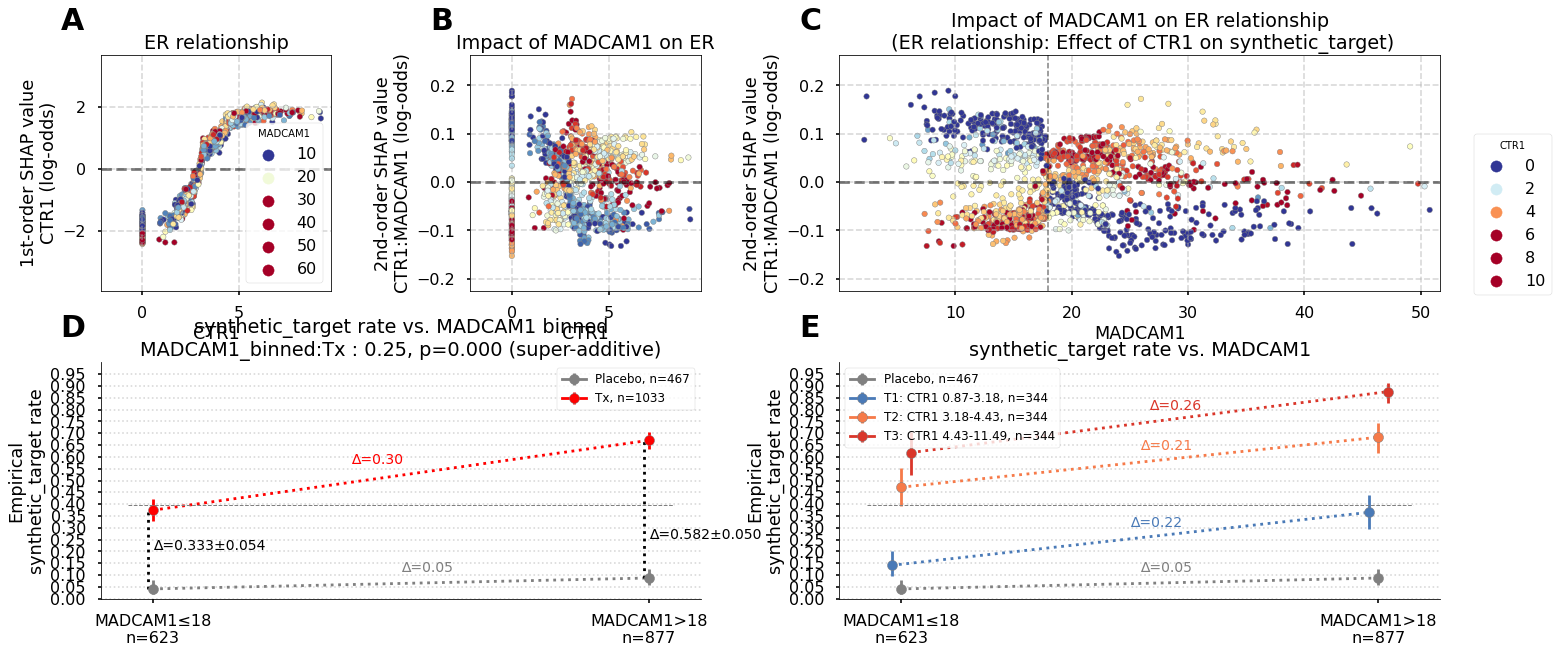

In [52]:
analysis.cutoff_analysis('MADCAM1', feature_thr=18, ylims=[0,1])

Interaction values in probability scale were not found; using log-odds scale
Hint: self.generate_shap_exposure_interaction_prob_df(exposure_var)
Interaction values in probability scale were not found; using log-odds scale
Hint: self.generate_shap_exposure_interaction_prob_df(exposure_var)
Interaction values in probability scale were not found; using log-odds scale
Hint: self.generate_shap_exposure_interaction_prob_df(exposure_var)
No dose_var was supplied assumming placebo pts using: ((df[exposure_var]==0)
No dose_var was supplied assumming Tx pts using: (df[exposure_var].isna()) | (df[exposure_var]>0)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


Tx-related risk difference for SEXN≤1.5 : 0.395
Tx-related risk difference for SEXN>1.5 : 0.538
Group with greater risk difference:  SEXN>1.5
synthetic_target rate for placebo SEXN≤1.5 (low-risk group): 0.086
synthetic_target rate for placebo SEXN>1.5 (high-risk group): 0.054
synthetic_target rate for Tx SEXN≤1.5 (low-risk group): 0.481
synthetic_target rate for Tx SEXN>1.5 (high-risk group): 0.592
 
    Note: Group 1 is the high risk group
    Asessing the extent to which the effect of the two factors together exceeds the effect of each considered individually 
    t = (p11-p00) - ((p10-p00) + (p01-p00)), where p11 is indicative of rate related to treatment and the high risk group, respectively.
    if t<0 sub-additive, while if t>0 super-additive meaning the effect of two factors together exceeds the effect of each considered indiviually
    Note: t = GROUP:TRT in the OLS model
    Analysis detailed in: https://www.degruyter.com/document/doi/10.1515/em-2013-0005/html
    
t = 0.143 ;

Boolean Series key will be reindexed to match DataFrame index.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


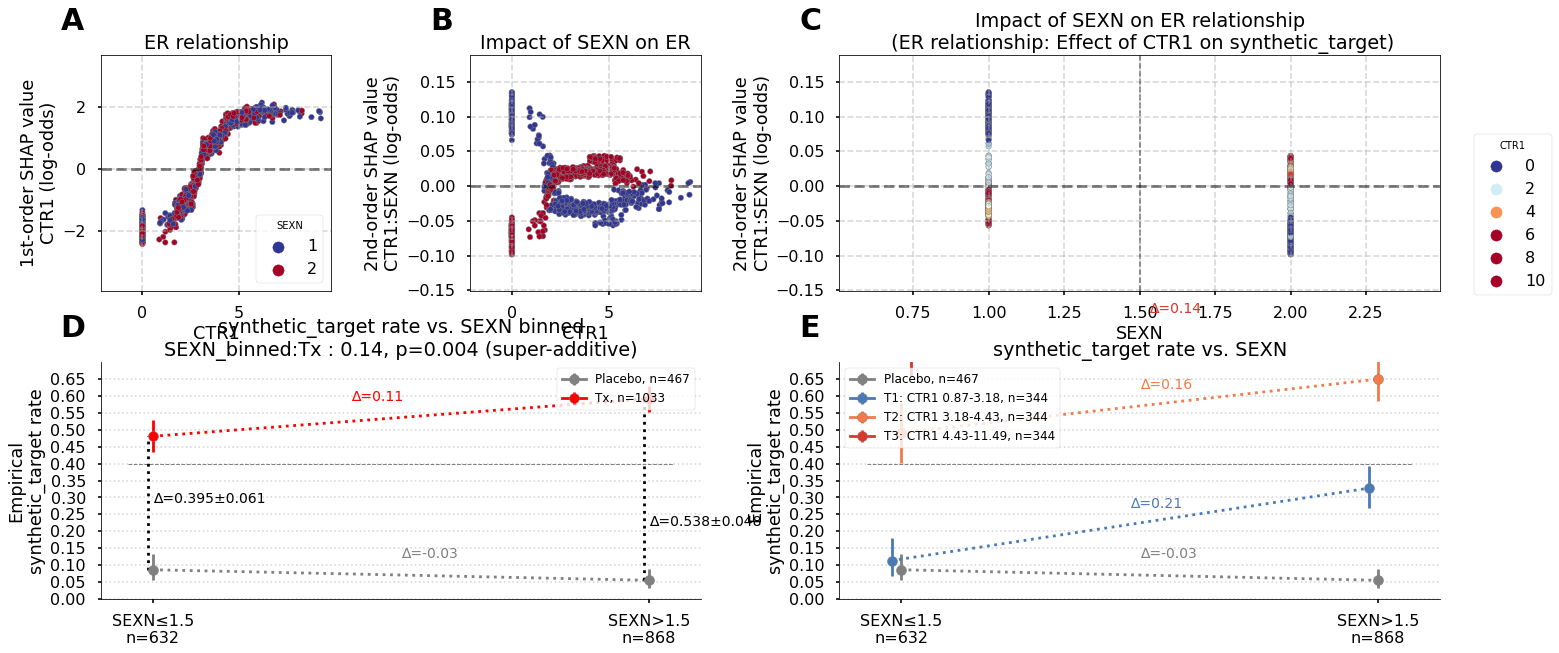

In [51]:
analysis.cutoff_analysis('SEXN', feature_thr=1.5, ylims=[0,1])

In [44]:
self = analysis

In [47]:
from shapml.utils.cutoff_analysis_fcns import add_annotations, binom_err, additive_interaction, shap_interaction_plot_cutoff
def cutoff_analysis(self, x='BHBA1C', y='HGLY≥2', feature_thr = None, exposure_var = 'Cminsd', dose_var = None, trt_arm_name='Tx', 
                    ms=10, mew=.5, annotation_font_size=14, ylims = [0, .7] , y_label_offset_1 = .05, y_label_offset_2 = .05, 
                    x_offset_1 = 0, x_offset_2 = 0, figsize=(24,10), show_interaction=True, save_fig=False, return_fig=False,
                    legend_font_size=12, return_table=False, interaction_type='additive', fig_labels=True, **kwargs):
    """
    kwargs get supplied to shap_interaction_plot_cutoff (i.e. selectionVec)
    """                
    # if type(df)==type(None):
    #     print('No df was supplied therefore, using self.df')
    def sep(count, nobs):
        p=count/nobs
        return np.sqrt(p*(1-p)/nobs)
    def sep_difference(count1, nobs1, count2,nobs2):
        return np.sqrt(sep(count1,nobs1)**2+sep(count2,nobs2)**2)

    try:
        df=pd.concat([self.df, self.meta_df.copy()],axis=1)                                        
    except:
        df=self.df.copy()
    if type(feature_thr)==type(None):
        feature_thr = df[x].median()
    feature_bins=[df[x].min(),feature_thr, df[x].max()]
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 8, hspace=.3,wspace=3)
    try: # This allows for generating cutoff analysis using features not in the 
        assert(x in self.df.columns)
        ax01 = fig.add_subplot(gs[0, 0:2])
        features = [x]
        features.extend(set(self.mdlFeatures).difference([x]))
        shap_interaction_plot_cutoff(self, x_feature=self.exposure_var, features=features, exposure_var=exposure_var, 
                            feature_thr=feature_thr, s=30, ylabel=f'1st-order SHAP value\n{self.exposure_var}', ax=ax01,
                            title_str="ER relationship", loc=4, bbox_to_anchor=(1, 0))
        ax02 = fig.add_subplot(gs[0, 2:4])
        shap_interaction_plot_cutoff(self, x_feature=self.exposure_var, features=[x], exposure_var=exposure_var, 
                            feature_thr=feature_thr, s=30, ylabel=f'2nd-order SHAP value\n{exposure_var}:{x}', 
                                    ax=ax02, show_legend=False, title_str=f"Impact of {x} on ER",**kwargs)

        ax03 = fig.add_subplot(gs[0, 4:])
        shap_interaction_plot_cutoff(self, x_feature=x, features=[x], exposure_var=exposure_var, 
                            feature_thr=feature_thr, s=30, ylabel=f'2nd-order SHAP value\n{exposure_var}:{x}', ax=ax03, bbox_to_anchor=(1.2, .7),**kwargs)
    except:
        
        pass

    ax1=fig.add_subplot(gs[1,0:4])
    # Plot Placebo:feature on ax1:
    color='gray'
    if type(dose_var)==type(None):
        print("No dose_var was supplied assumming placebo pts using: ((df[exposure_var]==0)")
        tmpDF = df[(df[exposure_var]==0)]
    else: 
        tmpDF = df[df[dose_var]==0]
    n=tmpDF.shape[0]
    tmpDF[x+'_binned'] = pd.cut(tmpDF[x], bins=feature_bins, include_lowest=True)
    errDF = tmpDF.groupby(x+'_binned').agg({y:['mean', binom_err, 'count']}).reset_index()
    errDF.columns = [x+'_binned', 'mean', 'binom_err', 'count']

    legend_label=f'Placebo, n={n}'
    placebo_errDF=errDF
    for idx in range(len(tmpDF[x+'_binned'].unique().categories)):
        currDF = errDF.iloc[idx,:]
        x_val = idx + x_offset_1#had this at left
        y_val= currDF['mean']
        yerr = np.array(currDF['binom_err']).reshape(-1,1)
        plt.errorbar(x=x_val, y=y_val, yerr=yerr, marker='o', ms=ms, mew=mew,mec='gray', color=color, 
                    label=legend_label if idx == 0 else None)
    plt.plot(errDF.index+x_offset_1, errDF['mean'], color=color, ls=':')
    plt.text(.5, errDF['mean'].mean()+y_label_offset_1, s="∆={:.2f}".format(errDF['mean'][1]-errDF['mean'][0]) ,color=color, fontsize=annotation_font_size)

    #Plot Tx:feature on ax1:
    color='red'
    if type(dose_var)==type(None):
        print("No dose_var was supplied assumming Tx pts using: (df[exposure_var].isna()) | (df[exposure_var]>0)")
        tmpDF = df[(df[exposure_var].isna()) | (df[exposure_var]>0)]
        dose_var = 'dose'
        df['dose'] = df.apply(lambda x: int(np.isnan(x[exposure_var]) | (x[exposure_var]>0)), axis=1)
    else: 
        tmpDF = df[df[dose_var]>0]
    n=tmpDF.shape[0]
    tmpDF[x+'_binned'] = pd.cut(tmpDF[x], bins=feature_bins, include_lowest=True)
    legend_label=f'{trt_arm_name}, n={n}'

    errDF = tmpDF.groupby(x+'_binned').agg({y:['mean', binom_err, 'count']}).reset_index()
    errDF.columns = [x+'_binned', 'mean', 'binom_err', 'count']
    tx_errDF = errDF.copy()
    for idx in range(len(tmpDF[x+'_binned'].unique().categories)):
        currDF = errDF.iloc[idx,:]
        x_val = idx + x_offset_1#had this at left
        y_val= currDF['mean']
        yerr = np.array(currDF['binom_err']).reshape(-1,1)
        ax1.errorbar(x=x_val, y=y_val, yerr=yerr, marker='o', ms=ms, mew=mew,mec='gray', color=color, 
                    label=legend_label if idx == 0 else None)
    ax1.plot(errDF.index+x_offset_1, errDF['mean'], color=color, ls=':')
    ax1.text(.4, errDF['mean'].mean()+y_label_offset_1, s="∆={:.2f}".format(errDF['mean'][1]-errDF['mean'][0]) ,color=color, fontsize=annotation_font_size)
    
    ax1.set_yticks(np.arange(ylims[0],ylims[1],.05))
    ax1.set_ylim([ylims[0],ylims[1]])
    ax1.set_xticks([0,1])
    ax1.set_xticklabels([f'{x}≤{feature_thr}\nn={(df[x]<=feature_thr).sum()}', f'{x}>{feature_thr}\nn={(df[x]>feature_thr).sum()}'])
    hl=df[y].mean()
    ax1.hlines(hl, ax1.get_xlim()[0], ax1.get_xlim()[1], color='gray', ls='--', lw=1)
    ax1.legend(loc=1, bbox_to_anchor=(1, 1), fontsize=legend_font_size)
    ax1.grid(alpha=.5, ls=':', axis='y')
    
    title_str = f"{y} rate vs. {x} binned"
    
    lm,t = additive_interaction(self, x=x, feature_thr=feature_thr) # This is used regardless of the type of interaction we show in the plot
    if show_interaction: 
        if interaction_type=='logistic':
            interaction_effect = get_tx_binned_feature_interaction_effect(df, dose_var=dose_var, x=x, feature_thr=feature_thr, y=y)
            title_str = title_str + f"\n{x}_binned:Tx : {np.round(interaction_effect['coef'],2)}, p={interaction_effect['P>|z|']}"
        elif interaction_type=='additive':
            interaction_effect = lm.loc['GROUP:TRT']
            title_str = title_str + "\n{}_binned:Tx : {:.2f}, p={:.3f}".format(x, interaction_effect['coef'], interaction_effect['P>|t|'])
            if t>0:
                title_str += " (super-additive)"
            elif t<0:
                title_str += " (sub-additive)"
    
    ax1.set_title(title_str)
    ax1.set_ylabel(f"Empirical\n{y} rate")    
    
    count1 = int(placebo_errDF['mean'][0]*placebo_errDF['count'][0]) # HGLY in placebo group with low feature values
    nobs1 = int(placebo_errDF['count'][0]) # N Placebo group with low feature values
    count2 = int(tx_errDF['mean'][0]*tx_errDF['count'][0]) # HGLY in Tx group with low feature values
    nobs2 = int(tx_errDF['count'][0]) # N Tx group with low feature values
    CI=np.round(sep_difference(count1=count1, nobs1=nobs1, count2=count2,nobs2=nobs2)*1.96,3)
    ax1.text(0, (tx_errDF['mean'][0]+placebo_errDF['mean'][0])/2, s="∆={:.3f}±{:.3f}".format(tx_errDF['mean'][0]-placebo_errDF['mean'][0],CI), color='black', fontsize=annotation_font_size)
    
    count1 = int(placebo_errDF['mean'][1]*placebo_errDF['count'][1]) # HGLY in placebo group with low feature values
    nobs1 = int(placebo_errDF['count'][1]) # N Placebo group with low feature values
    count2 = int(tx_errDF['mean'][1]*tx_errDF['count'][1]) # HGLY in Tx group with low feature values
    nobs2 = int(tx_errDF['count'][1]) # N Tx group with low feature values
    CI=np.round(sep_difference(count1=count1, nobs1=nobs1, count2=count2,nobs2=nobs2)*1.96,3)
    ax1.text(1, (tx_errDF['mean'][1]+placebo_errDF['mean'][1])/3, s="∆={:.3f}±{:.3f}".format(tx_errDF['mean'][1]-placebo_errDF['mean'][1], CI), color='black', fontsize=annotation_font_size)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.plot(np.array([0,0])-.01, [placebo_errDF['mean'][0], tx_errDF['mean'][0]], ':k')
    ax1.plot(np.array([1,1])-.01, [placebo_errDF['mean'][1], tx_errDF['mean'][1]], ':k')
    ###############################
    ax2 = fig.add_subplot(gs[1,4:])
    # Plot placebo: 
    color='gray'
    tmpDF = df[df[exposure_var]==0]
    n=tmpDF.count()[exposure_var]
    tmpDF[x+'_binned'] = pd.cut(tmpDF[x], bins=feature_bins, include_lowest=True)
    errDF = tmpDF.groupby(x+'_binned').agg({y:['mean', binom_err, 'count']}).reset_index()
    errDF.columns = [x+'_binned', 'mean', 'binom_err', 'count']
    errDF[exposure_var+'_bin'] = f"{0}"
    errDF[exposure_var+'_count'] = n
    legend_label=f'Placebo, n={n}'
    
    for idx in range(len(tmpDF[x+'_binned'].unique().categories)):
        currDF = errDF.iloc[idx,:]
        x_val = idx + x_offset_2#had this at left
        y_val= currDF['mean']
        yerr = np.array(currDF['binom_err']).reshape(-1,1)
        ax2.errorbar(x=x_val, y=y_val, yerr=yerr, marker='o', ms=ms, mew=mew,mec='gray', color=color, label=legend_label if idx == 0 else None)
    ax2.plot(errDF.index+x_offset_2, errDF['mean'], color=color, ls=':')
    ax2.text(.5, errDF['mean'].mean()+y_label_offset_2, s="∆={:.2f}".format(errDF['mean'][1]-errDF['mean'][0]) ,color=color, fontsize=annotation_font_size)
    # ax2.legend(loc=1, bbox_to_anchor=(.8, 1.5))

    # Plot Tertiles of exposure
    exposure_bins = 3
    # colors = sns.color_palette(palette='RdYlBu_r', n_colors=exposure_bins)
    colors = sns.color_palette(palette='RdYlBu_r', n_colors=8)
    colors = [colors[0], colors[6], colors[-1]]

    for i in range(exposure_bins):
        lwr = df[df[exposure_var]>0][exposure_var].quantile((1/exposure_bins)*i); 
        upr = df[df[exposure_var]>0][exposure_var].quantile((1/exposure_bins)*(i+1));
        tmpDF = df[df[exposure_var]>0][(df[exposure_var]>=lwr) & (df[exposure_var]<upr)]
        tmpDF[x+'_binned'] = pd.cut(tmpDF[x], bins=feature_bins, include_lowest=True)
        n=tmpDF.count()[exposure_var]
        legend_label=f'T{i+1}: {exposure_var} {np.round(lwr,2)}-{np.round(upr,2)}, n={n}'
        errDF = tmpDF.groupby(x+'_binned').agg({y:['mean', binom_err, 'count']}).reset_index()
        errDF.columns = [x+'_binned', 'mean', 'binom_err', 'count']
        errDF[exposure_var+'_bin'] = f"{np.round(lwr,2)}-{np.round(upr,2)}"
        errDF[exposure_var+'_count'] = n
        color=colors[i]
        x_offset = (i-(exposure_bins//2))*.02+x_offset_2
        for idx in range(len(tmpDF[x+'_binned'].unique().categories)):
            currDF = errDF.iloc[idx,:]
            x_val = idx + x_offset#had this at left
            y_val= currDF['mean']
            yerr = np.array(currDF['binom_err']).reshape(-1,1)
            ax2.errorbar(x=x_val, y=y_val, yerr=yerr, marker='o', ms=ms, mew=mew,mec='gray', color=color, 
                        label=legend_label if idx == 0 else None)
        ax2.plot(errDF.index+x_offset, errDF['mean'], color=color, ls=':')
        ax2.text(.5+x_offset, errDF['mean'].mean()+y_label_offset_2, s="∆={:.2f}".format(errDF['mean'][1]-errDF['mean'][0]) ,color=color, fontsize=annotation_font_size)
    ax2.set_ylim([ylims[0],ylims[1]])
    ax2.set_yticks(np.arange(ylims[0],ylims[1],.05))
    ax2.hlines(hl, ax2.get_xlim()[0], ax2.get_xlim()[1], color='gray', ls='--', lw=1)
    ax2.legend(loc=2, bbox_to_anchor=(0, 1), fontsize=legend_font_size)
    ax2.grid(alpha=.5, ls=':', axis='y')
    ax2.set_title(f"{y} rate vs. {x}")
    ax2.set_ylabel(f"Empirical\n{y} rate")    
    ax2.set_xticks([0,1])
    ax2.set_xticklabels([f'{x}≤{feature_thr}\nn={(df[x]<=feature_thr).sum()}', f'{x}>{feature_thr}\nn={(df[x]>=feature_thr).sum()}'])
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    plt.tight_layout()
    if fig_labels:
        add_annotations(fig, x_offset=-40, y_offset=25, fontsize=30, weight='bold')
    if save_fig:
        file_name= self.outputs_dir + f'{x}_interaction_plots.png'
        plt.savefig(file_name, bbox_inches='tight', dpi=300)
        print("Saved: ", file_name)
    
    placebo_errDF['TRT']=0
    tx_errDF['TRT']=1
    tab_out = pd.concat([placebo_errDF, tx_errDF])
    tab_out['Covariate'] = x
    tab_out=tab_out.rename(columns={x+"_binned":"bin"}).reset_index().rename(columns={'index': 'Group'})

    tab_out['Rate (%) (95% CI)'] = tab_out.apply(lambda x: "{:.2f} ({:.2f}, {:.2f})".format(x['mean']*100, x['binom_err'][0]*100, x['binom_err'][1]*100),axis=1)
    tab_out['SEP'] = tab_out.apply(lambda x: sep(int(x['mean']*x['count']), int(x['count'])), axis=1)

    # For the combined std: multiplying by 100 after taking the sqrt puts the std into the correct right order of magnitude.
    tab_out['Risk difference ± std (Tx-Placebo)'] = np.nan
    tab_out.loc[2, 'Risk difference ± std (Tx-Placebo)'] = "{:.2f}±{:.2f}".format((tab_out.loc[2, 'mean']-tab_out.loc[0, 'mean'])*100, 100*np.sqrt(tab_out.loc[0, 'SEP']**2+tab_out.loc[2, 'SEP']**2))
    tab_out.loc[3, 'Risk difference ± std (Tx-Placebo)'] = "{:.2f}±{:.2f}".format((tab_out.loc[3, 'mean']-tab_out.loc[1, 'mean'])*100, 100*np.sqrt(tab_out.loc[1, 'SEP']**2+tab_out.loc[3, 'SEP']**2))

    tab_out['Relative risk ± std (Tx/Placebo)'] = np.nan
    tab_out.loc[2, 'Relative risk ± std (Tx/Placebo)'] = "{:.2f}±{:.2f}".format(tab_out.loc[2, 'mean']/tab_out.loc[0, 'mean'], 100*np.sqrt((tab_out.loc[0, 'SEP']**2+tab_out.loc[2, 'SEP']**2)/tab_out.loc[0, 'mean']))
    tab_out.loc[3, 'Relative risk ± std (Tx/Placebo)'] = "{:.2f}±{:.2f}".format(tab_out.loc[3, 'mean']/tab_out.loc[1, 'mean'], 100*np.sqrt((tab_out.loc[1, 'SEP']**2+tab_out.loc[3, 'SEP']**2)/tab_out.loc[1, 'mean']))

    
    s= "{:.3f}, p={:.5f}".format(interaction_effect['coef'], interaction_effect['P>|t|'])
    if t>0: 
        s+= " (super-additive)"
    else:
        s+= " (sub-additive)"
    tab_out['Additive interaction'] = np.nan
    tab_out.loc[3,'Additive interaction'] = s
    tab_out=tab_out[['Covariate', 'bin', 'count', 'Rate (%) (95% CI)', 'Risk difference ± std (Tx-Placebo)', 'Additive interaction', 'Relative risk ± std (Tx/Placebo)', 
            'Group', 'mean', 'binom_err', 'TRT', 'SEP']]

    if return_fig & return_table:
        return fig, tab_out
    elif return_fig:
        return fig
    elif return_table: 
        return tab_out

Interaction values in probability scale were not found; using log-odds scale
Hint: self.generate_shap_exposure_interaction_prob_df(exposure_var)
Interaction values in probability scale were not found; using log-odds scale
Hint: self.generate_shap_exposure_interaction_prob_df(exposure_var)
Interaction values in probability scale were not found; using log-odds scale
Hint: self.generate_shap_exposure_interaction_prob_df(exposure_var)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


Tx-related risk difference for MADCAM1≤18 : 0.333
Tx-related risk difference for MADCAM1>18 : 0.582
Group with greater risk difference:  MADCAM1>18
synthetic_target rate for placebo MADCAM1≤18 (low-risk group): 0.041
synthetic_target rate for placebo MADCAM1>18 (high-risk group): 0.088
synthetic_target rate for Tx MADCAM1≤18 (low-risk group): 0.374
synthetic_target rate for Tx MADCAM1>18 (high-risk group): 0.67
 
    Note: Group 1 is the high risk group
    Asessing the extent to which the effect of the two factors together exceeds the effect of each considered individually 
    t = (p11-p00) - ((p10-p00) + (p01-p00)), where p11 is indicative of rate related to treatment and the high risk group, respectively.
    if t<0 sub-additive, while if t>0 super-additive meaning the effect of two factors together exceeds the effect of each considered indiviually
    Note: t = GROUP:TRT in the OLS model
    Analysis detailed in: https://www.degruyter.com/document/doi/10.1515/em-2013-0005/html
   

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


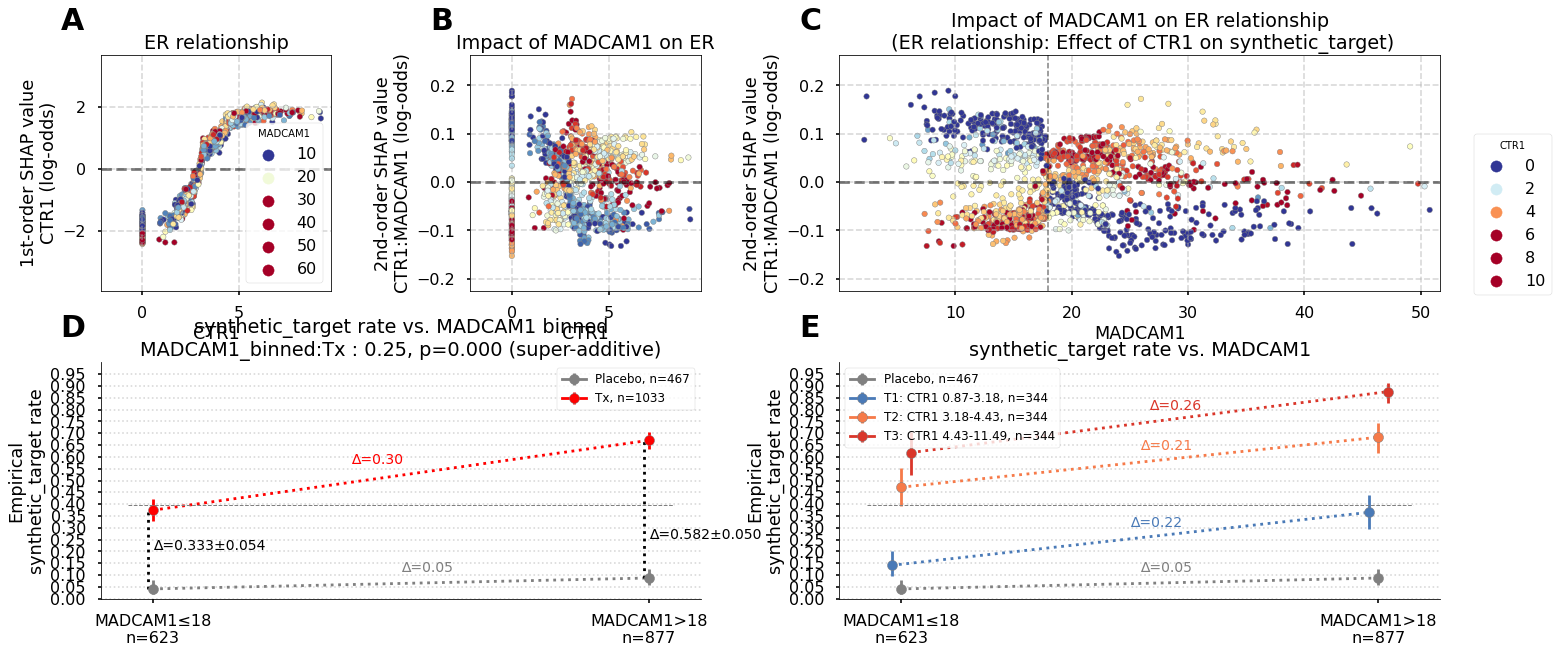

In [48]:
cutoff_analysis(self, x='MADCAM1', y='synthetic_target', exposure_var='CTR1', dose_var='Treatment_Flag', feature_thr=18, 
               ylims=[0, 1])